## Решаем задачу регрессии для CC50

**Для этой задачи PCA дал хуже метрики, поэтому для регрессии CC50 этот метод уменьшения размерности не используется**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.svm import SVR
from joblib import dump

from sklearn.tree import DecisionTreeRegressor, plot_tree

from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import GradientBoostingRegressor

In [4]:
df = pd.read_excel('../Data/Processed/processed_info.xlsx')

# Сразу удалим IC50, mM и SI, так как они рассчитываются друг через друга.
df.drop(['IC50, mM', 'SI'], axis=1, inplace=True)

## Линейная регрессия

In [3]:
X = df.drop(['CC50, mM'], axis=1)
y = df['CC50, mM']

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Обучение линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Предсказание и оценка модели
y_pred = model.predict(X_test)

# Метрики качества
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Squared Error (MSE): 329257.5813
R-squared (R²): 0.3649


## Elastic Net

E:\Programs\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.267e+07, tolerance: 2.424e+04
  model = cd_fast.enet_coordinate_descent(
E:\Programs\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.108e+07, tolerance: 2.318e+04
  model = cd_fast.enet_coordinate_descent(
E:\Programs\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.218e+07, tolerance: 2.399e

Лучшие параметры: {'alpha': 0.1, 'l1_ratio': 0.7}
MSE: 279665.9278
R²: 0.4606


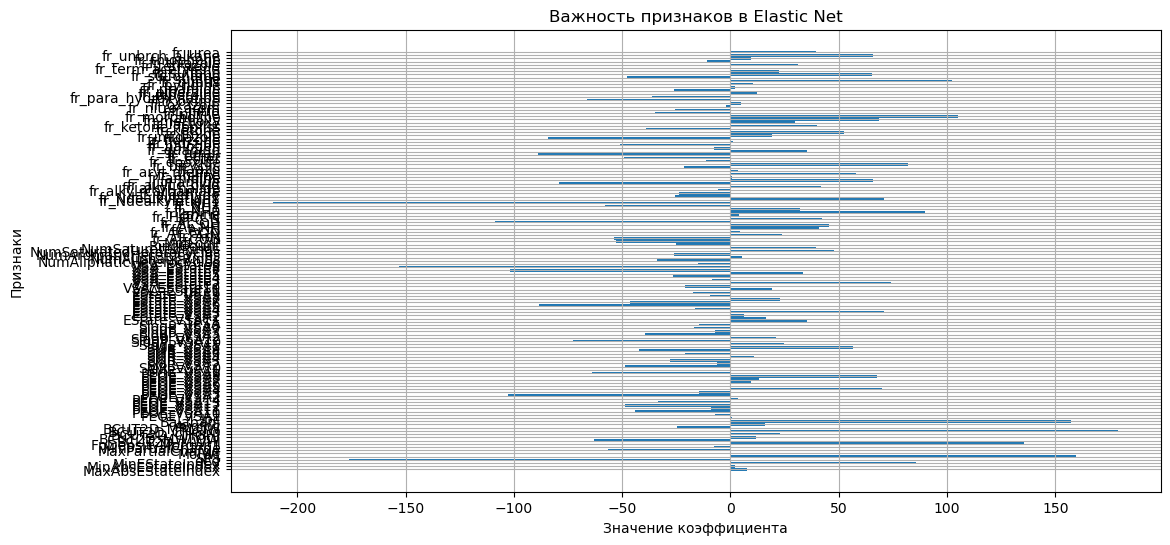

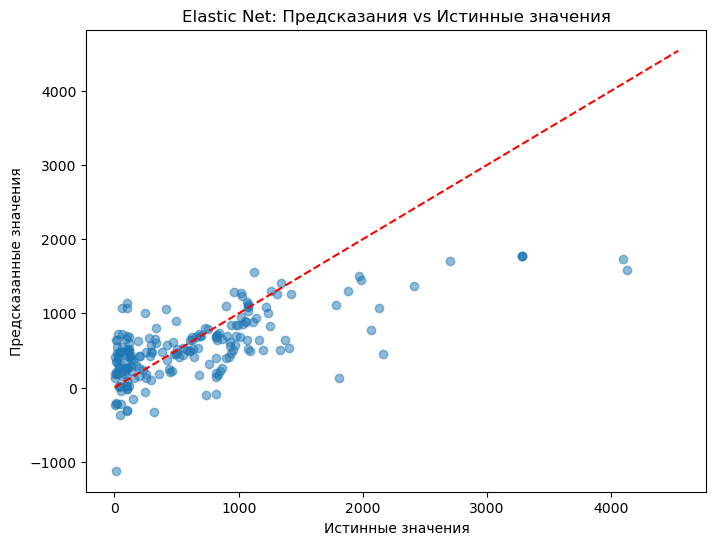

In [6]:
X = df.drop(['CC50, mM'], axis=1)
y = df['CC50, mM']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

elastic_net = ElasticNet()

# Подбор гиперпараметров с помощью GridSearchCV
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],  # сила регуляризации
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # соотношение L1/L2 (0 = Ridge, 1 = Lasso)
}

grid_search = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
print(f"Лучшие параметры: {grid_search.best_params_}")

y_pred = best_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

plt.figure(figsize=(12, 6))
features = X.columns
coef = best_model.coef_
plt.barh(features, coef)
plt.xlabel('Значение коэффициента')
plt.ylabel('Признаки')
plt.title('Важность признаков в Elastic Net')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Elastic Net: Предсказания vs Истинные значения')
plt.show()

## Метод опорных векторов

Fitting 5 folds for each of 144 candidates, totalling 720 fits

Лучшие параметры: {'C': 100, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
Лучший MSE (на кросс-валидации): 270470.6381886935

Результаты на тестовых данных:
MSE: 300010.6482
R²: 0.4213


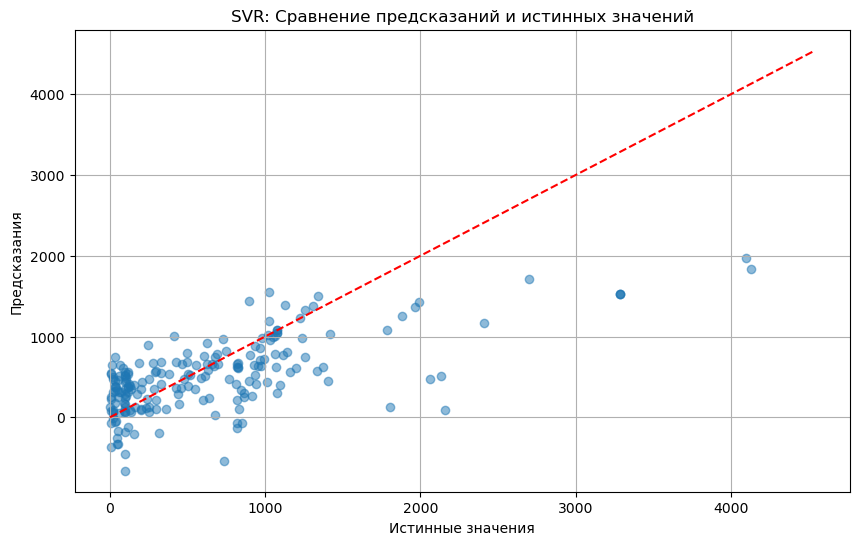

In [9]:
X = df.drop(['CC50, mM'], axis=1)
y = df['CC50, mM']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1],
    'epsilon': [0.01, 0.1, 0.5]
}

svr = SVR()
grid_search = GridSearchCV(
    estimator=svr,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train_scaled, y_train)

print("\nЛучшие параметры:", grid_search.best_params_)
print("Лучший MSE (на кросс-валидации):", -grid_search.best_score_)

best_svr = grid_search.best_estimator_

y_pred = best_svr.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nРезультаты на тестовых данных:")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

# 8. Визуализация результатов
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказания')
plt.title('SVR: Сравнение предсказаний и истинных значений')
plt.grid(True)
plt.show()

## Деревья решений

Лучшие параметры: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
MSE: 309730.7772
R²: 0.4026


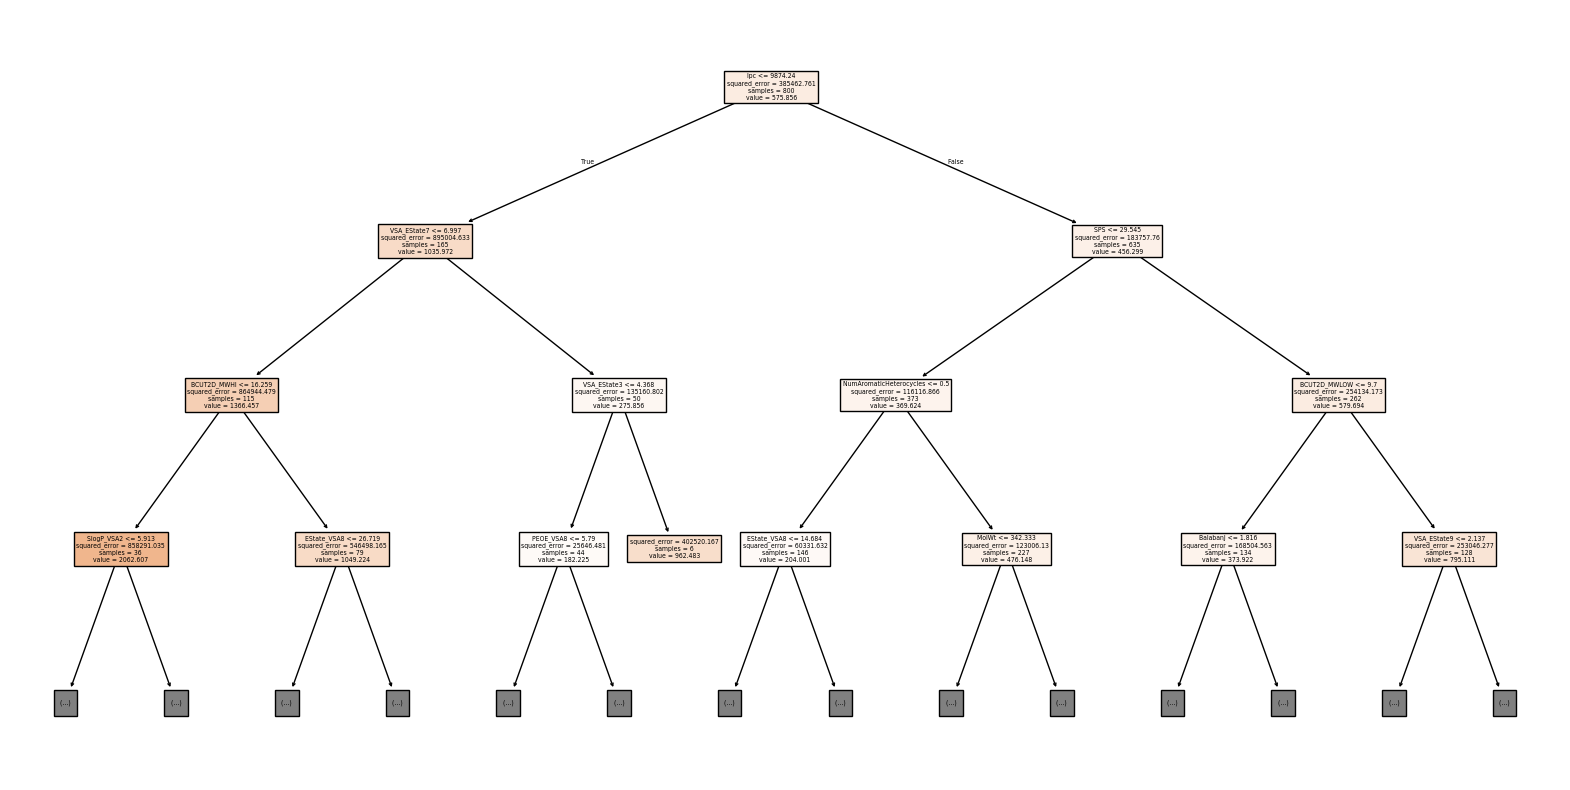

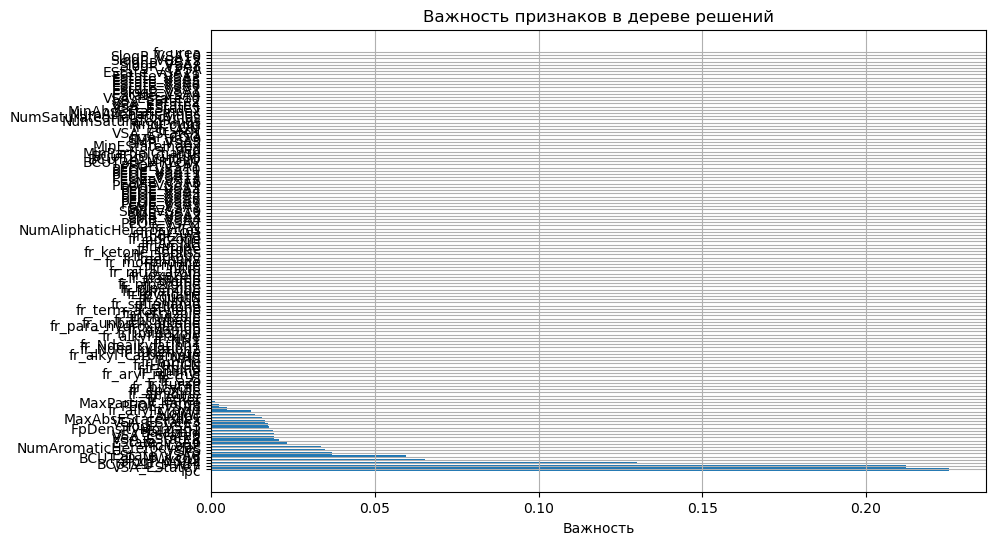

In [11]:
X = df.drop(['CC50, mM'], axis=1)
y = df['CC50, mM']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_reg = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(dt_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_dt_reg = grid_search.best_estimator_
print("Лучшие параметры:", grid_search.best_params_)

y_pred = best_dt_reg.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")

plt.figure(figsize=(20, 10))
plot_tree(best_dt_reg, max_depth=3, feature_names=X.columns, filled=True)
plt.show()

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_dt_reg.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Важность признаков в дереве решений')
plt.xlabel('Важность')
plt.grid(True)
plt.show()

## Случайный лес

Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
MSE: 206953.7964
R²: 0.6008


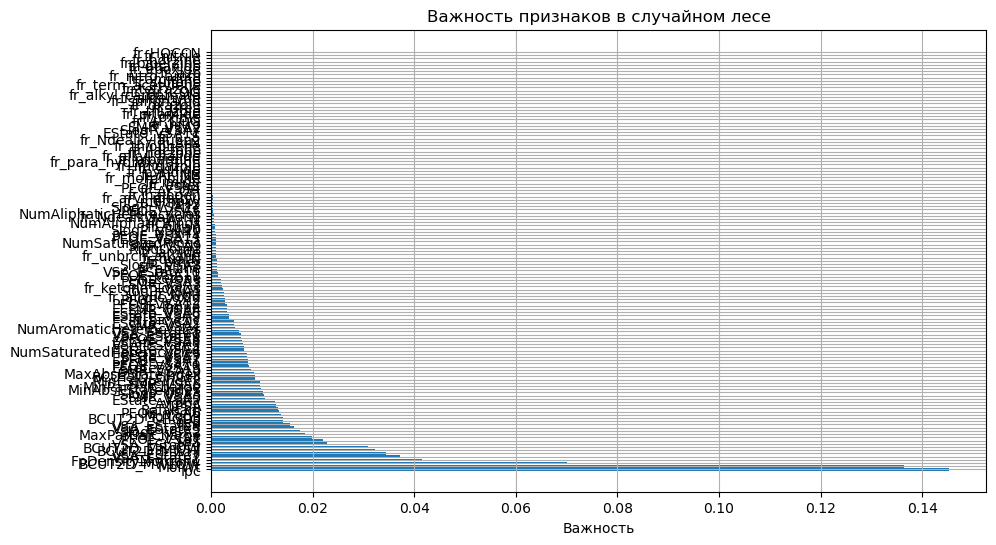

In [13]:
X = df.drop(['CC50, mM'], axis=1)
y = df['CC50, mM']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],   # Количество деревьев
    'max_depth': [None, 5, 10],       # Максимальная глубина
    'min_samples_split': [2, 5],      # Минимальное число образцов для разделения
    'min_samples_leaf': [1, 2]        # Минимальное число образцов в листе
}

rf_reg = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(rf_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_rf_reg = grid_search.best_estimator_
print("Лучшие параметры:", grid_search.best_params_)

y_pred = best_rf_reg.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf_reg.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Важность признаков в случайном лесе')
plt.xlabel('Важность')
plt.grid(True)
plt.show()

## Градиентный бустинг

In [6]:
X = df.drop(['CC50, mM'], axis=1)
y = df['CC50, mM']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gbr = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"R² Score: {r2}")

MSE: 227914.31873018484
R² Score: 0.5603930086435167


### Сравнительный анализ моделей машинного обучения

На основе представленных результатов проведем сравнение моделей по двум ключевым метрикам: **MSE (среднеквадратичная ошибка)** и **R² (коэффициент детерминации)**. Чем ниже MSE и чем ближе R² к 1, тем лучше модель.

---

#### **Ранжирование моделей по качеству** (по убыванию R²):
1. **Случайный лес**  
   - R²: **0.6008**  
   - MSE: **206953.7964**  
   - *Лучшая модель среди всех.*  

2. **Градиентный бустинг**  
   - R²: **0.5604**  
   - MSE: **227914.3187**

3. **Elastic Net**  
   - R²: **0.4606**  
   - MSE: **279665.9278**  
   - *Лучше линейной регрессии, но уступает ансамблевым методам.*  

4. **Метод опорных векторов (SVR)**  
   - R²: **0.4213**  
   - MSE: **300010.6482**  
   - *Хуже Elastic Net, но лучше деревьев решений.*  

5. **Деревья решений**  
   - R²: **0.4026**  
   - MSE: **309730.7772**  
   - *Проигрывает другим методам, кроме линейной регрессии.*  

6. **Линейная регрессия**  
   - R²: **0.3649**  
   - MSE: **329257.5813**  
   - *Худший результат, но как базовый подход.*  

---

### **Рекомендации по улучшению**
1. **Для случайного леса и градиентного бустинга:**  
   - Попробовать больше `n_estimators`.  
   - Использовать `GridSearchCV` для более тонкой настройки.  
   - Добавить feature engineering (например, полиномиальные признаки).  

2. **Если важен баланс между точностью и скоростью:**  
   - Выбрать **Elastic Net** (лучше линейной регрессии).  

3. **Проверить данные:**  
   - Возможны выбросы, которые ухудшают MSE.  
   - Нормализовать/стандартизировать признаки для SVR и линейных моделей.  

4. **Альтернативные модели:**  
   - XGBoost/LightGBM (часто дают лучший результат, чем случайный лес).  
   - Нейронные сети (если данных достаточно).

   
---

Таким образом, сравнены различные модели с настройкой гиперпараметров, сделаны выводы о применимости методов, даны рекомендации по улучшению.